In [2]:
import pandas as pd
from src.modelado import categorizar_horas
from src.modelado import dividir_variables
from src.modelado import dividir_datos
from src.modelado import pipeline_preprocesamiento
from src.modelado import entrenar_modelo
from src.modelado import calcular_matriz_confusion
from src.modelado import graficar_matriz_confusion
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv("../data/tattoo_studio_clean.csv")
df.head()

,Age,Gender,Day_of_Week,Session_Type,Tattoo_Size,Tattoo_Style,Artist_Name,Session_Hours,Customer_Satisfaction
0,46,Female,Friday,Pre-booked,Sleeve/Back,Minimalist,Artist B,9,3
1,32,Male,Saturday,Walk-in,Small,Custom,Artist C,1,2
2,25,Male,Friday,Pre-booked,Sleeve/Back,Custom,Artist A,10,1
3,38,Female,Friday,Pre-booked,Medium,Script,Artist D,4,4
4,36,Male,Wednesday,Pre-booked,Sleeve/Back,Tribal,Artist B,10,1


In [4]:
df["Session_Hours_Cat"] = df["Session_Hours"].apply(categorizar_horas)

In [5]:
y = df["Session_Hours_Cat"]
X = df.drop(columns=["Session_Hours", "Session_Hours_Cat"])

In [6]:
X_train, X_test, y_train, y_test = dividir_datos(X, y)

In [7]:
preprocesamiento = pipeline_preprocesamiento(X)

In [8]:
modelo = entrenar_modelo(preprocesamiento, X_train, y_train)

In [9]:
y_pred = modelo.predict(X_test)
cm = calcular_matriz_confusion(y_test, y_pred)
cm

array([[232,  15,   0],
       [ 34,  81,   6],
       [  0,   1,  31]])

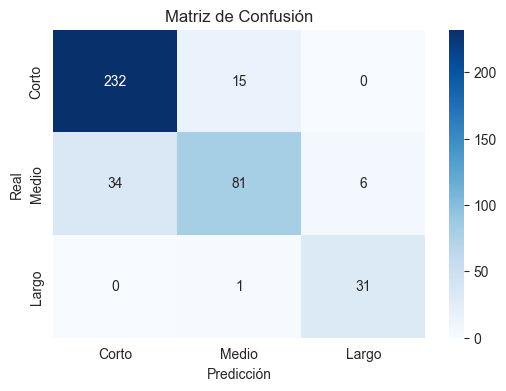

In [10]:
graficar_matriz_confusion(cm)


In [15]:
horas_reales = df.loc[X_test.index, "Session_Hours"]

In [14]:
rango_categorias = {
    "Corto": "0–3 horas",
    "Medio": "3–6 horas",
    "Largo": "6+ horas"
}
comparacion = pd.DataFrame({
    "Horas_Reales": horas_reales.values,
    "Predicción_Categoría": y_pred
})
comparacion["Rango_Predicción"] = comparacion["Predicción_Categoría"].map(rango_categorias)
comparacion.head()

,Horas_Reales,Predicción_Categoría,Rango_Predicción
0,1,Corto,0–3 horas
1,3,Medio,3–6 horas
2,3,Corto,0–3 horas
3,2,Corto,0–3 horas
4,2,Corto,0–3 horas


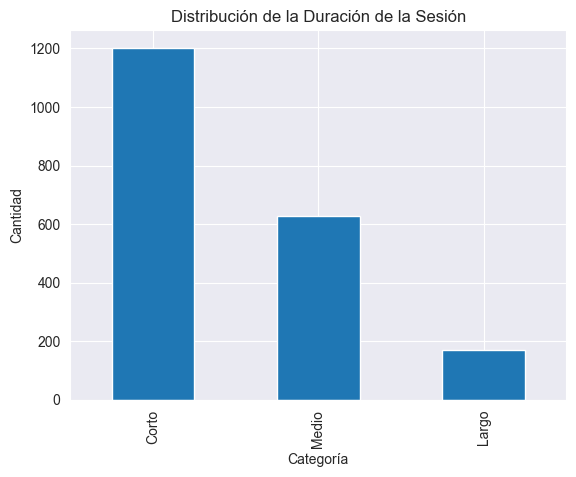

In [12]:
df["Session_Hours_Cat"].value_counts().plot(kind="bar")
plt.title("Distribución de la Duración de la Sesión")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")
plt.show()

In [ ]:
df_clean = df.copy()
df_clean["Predicted_Session"] = modelo.predict(X)

In [ ]:
df.info()